# GmGM and GLasso on an example scRNA-seq dataset

In this notebook, we will look at an scRNA-seq dataset ([Spatio-temporal immune zonation of the human kidney](https://www.ebi.ac.uk/gxa/sc/experiments/E-HCAD-10/results/tsne), with [an associated paper](https://pubmed.ncbi.nlm.nih.gov/31604275/)).  It has 30,000 cells, so make sure to download it early!  The code to set your environment up and download the data is given in `setup.ipynb`; run that first.

By the end of the notebook, you will have first-hand experience using these two algorithms.

## Dependencies

First, we need to load our dependencies.  The only 'core' dependencies, needed to load the data and run GmGM and GLasso, are scanpy, GmGM, and sklearn; the other packages are there to help us make the tutorial, but are not essential to the algorithms themselves (rather, they are used to analyze results).

In [1]:
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import GmGM
import warnings
import seaborn as sns
import scipy.sparse as sparse
import pandas as pd
import anndata as ad
import igraph as ig
from typing import Optional, Literal
from sklearn.covariance import graphical_lasso as glasso
from sklearn.preprocessing import StandardScaler
from gprofiler import GProfiler
import os
import shutil

plt.style.use('tableau-colorblind10')

In [2]:
# This establishes the directory that the data will be loaded from
# hopefully you will have already downloaded it in `setup.ipynb`, 
# so this will just load the dataset from the file.
sc._settings.ScanpyConfig.datasetdir = Path('../data/')
adata = sc.datasets.ebi_expression_atlas(
    accession='E-HCAD-10',
)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

The gene names are stored as ENSG codes, so let's get the (human-readable) external gene names as well.

In [3]:
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"]
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.var_names)]

# Add to adata
adata.var["external_gene_name"] = "Not in Biomart"
adata.var.loc[adata.var_names.isin(mapping.index), "external_gene_name"] = mapping["external_gene_name"]
adata.var[adata.var["external_gene_name"].isna()] = "Biomart NaN"

In [4]:
adata.var["external_gene_name"]

ENSG00000000003                     TSPAN6
ENSG00000000005                       TNMD
ENSG00000000419                       DPM1
ENSG00000000457                      SCYL3
ENSG00000000460                      FIRRM
                            ...           
ENSG00000289695                Biomart NaN
ENSG00000289697                Biomart NaN
ENSG00000289700                Biomart NaN
ENSG00000289701                Biomart NaN
ENSG00000289716    XNDC1N-ZNF705EP-ALG1L9P
Name: external_gene_name, Length: 26385, dtype: object

In [5]:
# Remove some pesky NaNs from the data, to make downstream analysis easier
adata.obs['inferred cell type'] = adata.obs['Factor Value[inferred cell type - authors labels]'].cat.add_categories("unknown").fillna("unknown")
adata.obs['inferred cell type']

4834STDY7002875_S1_L001-AAAATGAAGCCAGTAG                      unknown
4834STDY7002875_S1_L001-AAACCAATCTTCGGTC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAACACAC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAGAAATG                      unknown
4834STDY7002875_S1_L001-AAACCTCAGGAGCGAG                      unknown
                                                      ...            
FCAImmP7579215_S1_L001-TTTGTCAAGATATGGT     distal renal vesicle cell
FCAImmP7579215_S1_L001-TTTGTCAAGGAGTCTG                       unknown
FCAImmP7579215_S1_L001-TTTGTCACACAGCGTC           cap mesenchyme cell
FCAImmP7579215_S1_L001-TTTGTCACATTAACCG             fibroblast type 1
FCAImmP7579215_S1_L001-TTTGTCATCATGTCTT             stroma progenitor
Name: inferred cell type, Length: 31711, dtype: category
Categories (45, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'cap mesenchyme cell', ..., 'proximal renal vesicle cell', 'proximal ureteric bud cell', 'stroma progenitor

# Preprocessing

Here we will do some simple preprocessing of the data.  The goal will be to remove low-quality cells and genes; we will also log-transform the data.

For this we can rely on the `scanpy` library, whose ecosystem fills the niche in Python that Seurat does in R.

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

**How did we choose the cutoff values?**

These were mostly arbitrary.  We did try to choose a cutoff near the "bend" in the graphs you will see below.  After running through the notebook once, we would recommend coming back and seeing to what extent choosing different values affects the result.

In [7]:
# Quality Control Cutoffs
# feel free to change! they are fairly arbitrary

# Keep cells who are expressed in at least __ genes
n_genes_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all genes
cells_total_counts_cutoff = 10_000

# Keep genes who are expressed in at least __ cells
n_cells_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all cells
genes_total_counts_cutoff = 50_000

8884 cells kept (28.02%)
687 genes kept (2.17%)


View of AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[ind

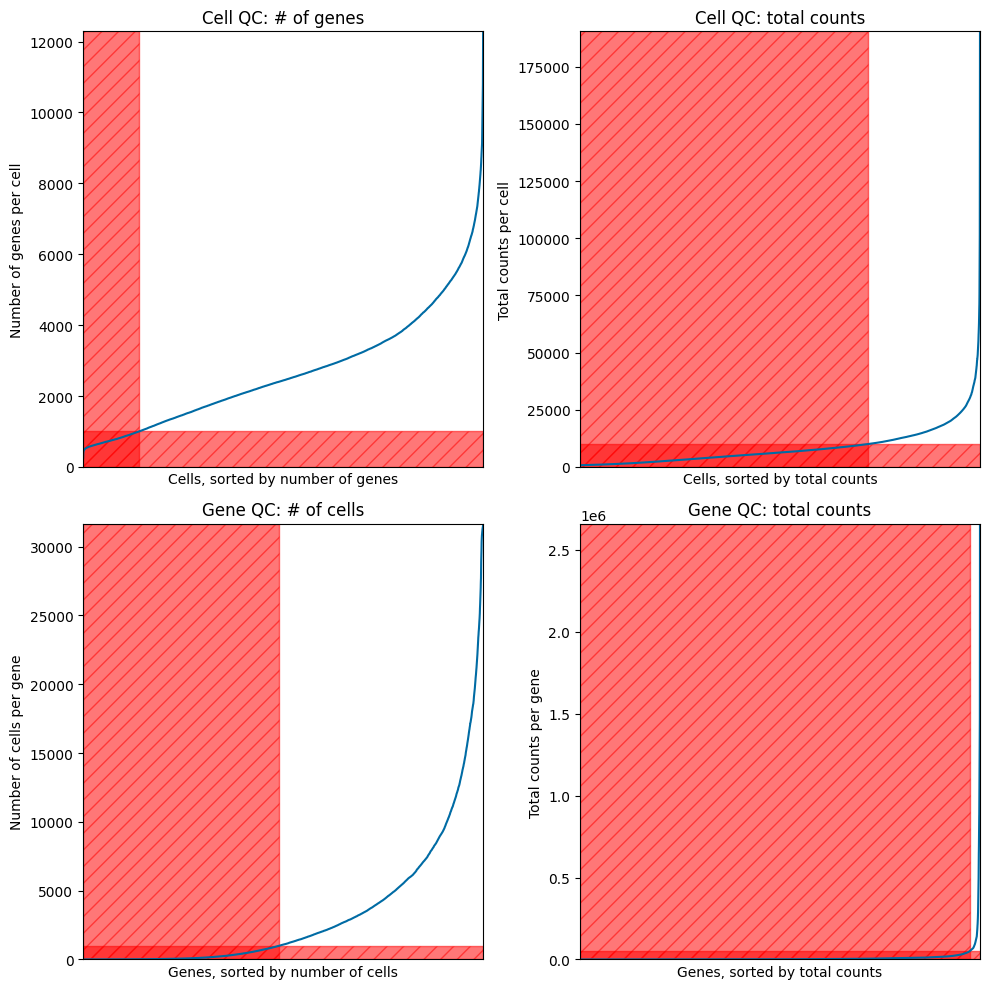

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs.flatten()

# Number of genes
adata.obs['n_genes_by_counts'].sort_values().plot(ax=ax1)
ax1.set_xticks([])
ax1.set_ylabel("Number of genes per cell")
ax1.set_xlabel("Cells, sorted by number of genes")
ax1.set_title("Cell QC: # of genes")
ax1.set_ylim(0, adata.obs['n_genes_by_counts'].max())
ax1.set_xlim(0, adata.obs['n_genes_by_counts'].shape[0])
ax1.axhspan(0, n_genes_by_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_1 = ~(adata.obs['n_genes_by_counts'] < n_genes_by_counts_cutoff)
ax1.axvspan(0, (~cells_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of genes
adata.obs['total_counts'].sort_values().plot(ax=ax2)
ax2.set_xticks([])
ax2.set_ylabel("Total counts per cell")
ax2.set_xlabel("Cells, sorted by total counts")
ax2.set_title("Cell QC: total counts")
ax2.set_ylim(0, adata.obs['total_counts'].max())
ax2.set_xlim(0, adata.obs['total_counts'].shape[0])
ax2.axhspan(0, cells_total_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_2 = ~(adata.obs['total_counts'] < cells_total_counts_cutoff)
ax2.axvspan(0, (~cells_keep_2).sum(), color="#FF000088", hatch='//')

# Number of cells
adata.var['n_cells_by_counts'].sort_values().plot(ax=ax3)
ax3.set_xticks([])
ax3.set_ylabel("Number of cells per gene")
ax3.set_xlabel("Genes, sorted by number of cells")
ax3.set_title("Gene QC: # of cells")
ax3.set_ylim(0, adata.var['n_cells_by_counts'].max())
ax3.set_xlim(0, adata.var['n_cells_by_counts'].shape[0])
ax3.axhspan(0, n_cells_by_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_1 = ~(adata.var['n_cells_by_counts'] < n_cells_by_counts_cutoff)
ax3.axvspan(0, (~genes_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of cells
adata.var['total_counts'].sort_values().plot(ax=ax4)
ax4.set_xticks([])
ax4.set_ylabel("Total counts per gene")
ax4.set_xlabel("Genes, sorted by total counts")
ax4.set_title("Gene QC: total counts")
ax4.set_ylim(0, adata.var['total_counts'].max())
ax4.set_xlim(0, adata.var['total_counts'].shape[0])
ax4.axhspan(0, genes_total_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_2 = ~(adata.var['total_counts'] < genes_total_counts_cutoff)
ax4.axvspan(0, (~genes_keep_2).sum(), color="#FF000088", hatch='//')

fig.tight_layout()

cells_keep = cells_keep_1 & cells_keep_2
genes_keep = genes_keep_1 & genes_keep_2
print(f"{cells_keep.sum()} cells kept ({cells_keep.sum()/adata.shape[0]:.2%})")
print(f"{genes_keep.sum()} genes kept ({genes_keep.sum()/adata.shape[0]:.2%})")

# Filter the adata
fadata = adata[cells_keep, genes_keep]
fadata

**Should we normalize counts to sum to one?**

It's quite reasonable to do, as RNA data is inherently 'compositional'; the raw amount of one gene does not matter as much as its expression relative to other genes in the same cell.  Normalizing to sum to one accounts for this.  However, this ruins the conditional dependency structure (at least, theoretically).

Suppose there are three genes A, B, C such that A + B + C = 1.  Conditioning over C, we have that A + B = 1 - C, where the right hand side is a known constant.  Thus, knowledge of A directly determines B, and vice versa - they are conditionally dependent!  We have forced every gene to be conditionally dependent.

In practice, this type of conditional dependency violates the assumptions of our models (Gaussian copula), so we might not pick up on it - but it's still a model mismatch.

As a default, we have not normalized the counts.  However, if you uncomment the cell below then you will see the results.  Run with the non-normalized counts first, and come back here only if you have time.  (When we ran this, we found the results were broadly similar regardless if you normalized or not)

In [9]:
#sc.pp.normalize_total(adata, target_sum=1e6)

In [10]:
# Log transform (in place)
sc.pp.log1p(adata)
sc.pp.log1p(fadata)
fadata

/home/codespace/.python/current/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:401: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

# Visualization

The following parameters are fairly important.  When doing PCA, we need to pick the number of components to keep (`N_COMPS`), and when creating a nearest neighbors graph for UMAP we need to pick the number of neighbors (`N_NEIGHBORS`).  They are also parameters for our algorithm GmGM, as that involves PCA and results in a graph - although in the case of GmGM, `N_NEIGHBORS` represents the average amount of neighbors we want each vertex to have, rather than a minimum.

We picked the values we did because we found them to work well on past datasets.  In fact, we often found one could reduce `N_COMPS` to 10 and still have GmGM work well.  `N_COMPS` can also be more rigorously picked, using the concept of 'explained variance'.  The idea is to pick a large enough value such that the remaining dataset still explains much of the original variance in the dataset.

One can either have a pre-selected variance threshold one wants to keep (such as 60%), or one can pick only those components before the 'bend' in the graph, under the argument that the remaining components represent noise.  One can also use other methods; feel free to test them out here.

In [11]:
# Parameters (feel free to change these)
N_COMPS = 50
N_NEIGHBORS = 10

Text(0.5, 1.0, 'Explained variance of filtered dataset (cells)')

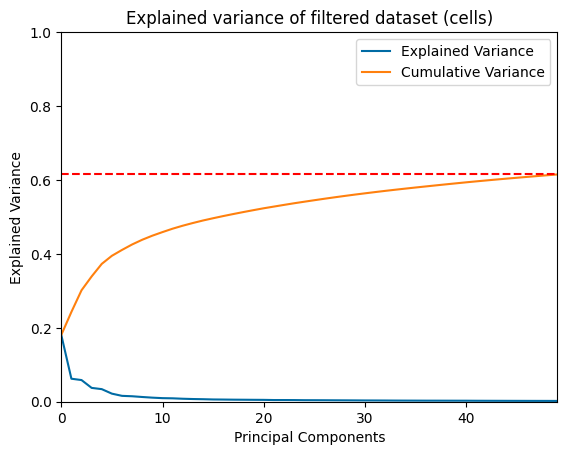

In [12]:
sc.pp.pca(fadata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fadata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (cells)")

In [13]:
# Should take around a minute to run
sc.pp.neighbors(fadata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fadata)

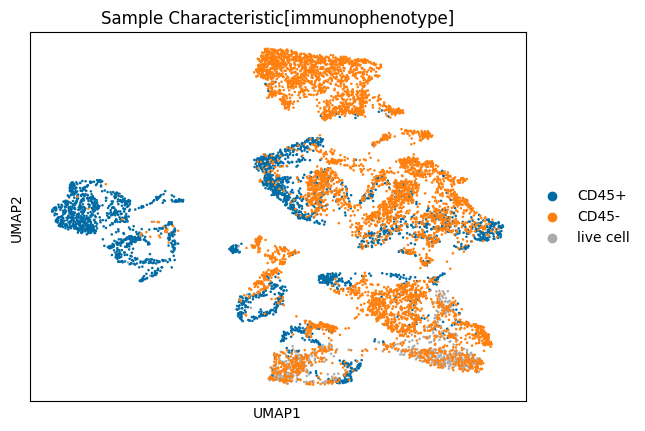

In [14]:
sc.pl.umap(fadata, color=['Sample Characteristic[immunophenotype]'])

In [15]:
# Let's look at the genes now!
fbdata = fadata.transpose()

Text(0.5, 1.0, 'Explained variance of filtered dataset (genes)')

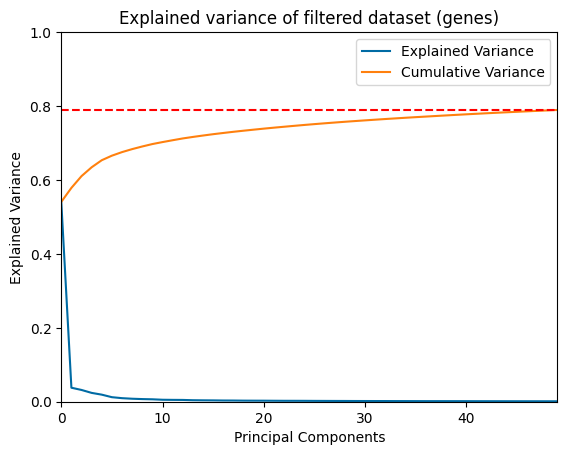

In [16]:
sc.pp.pca(fbdata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fbdata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (genes)")

In [17]:
# Should be very quick to run
sc.pp.neighbors(fbdata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fbdata)

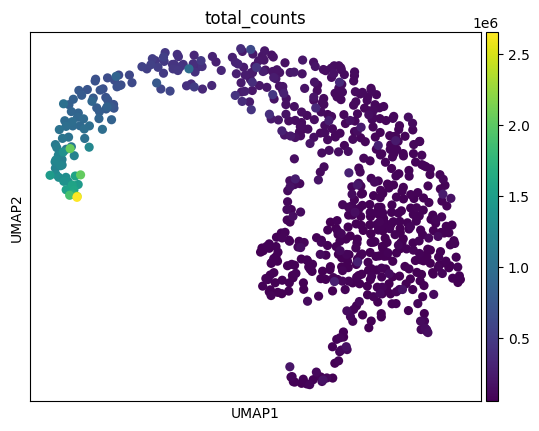

In [18]:
sc.pl.umap(fbdata, color=['total_counts'])

# Graphical Models

Here, we will run both GmGM and GLasso.

GmGM is a multi-axis method; i.e, it doesn't make an independence assumption and simultaneously gives results for both cells and genes.  It does not use regularization, but rather global thresholding.

GLasso is a single-axis method; we were not able to get it to produce a cell graph in reasonable time, so in this tutorial we will focus on its gene graph.  It uses L1 regularization, and makes an independence assumption.

## GmGM

In [19]:
# Note that GmGM natively accepts AnnData and MuData, i.e. we could pass
# fadata into the algorithm directly, rather than wrapping it
# in `GmGM.Dataset`.  However more general datastructures need to be wrapped,
# so in this tutorial we will use the most general way

dataset = GmGM.Dataset(
    dataset={"data": fadata.X},
    structure={"data": ("cell", "gene")}
)

output = GmGM.GmGM(
    dataset,
    to_keep=N_NEIGHBORS, # how many edges per cell (on average) should we keep
    threshold_method="overall-col-weighted", # method of keeping top genes
    min_edges={"cell": 5, "gene": 3}, # to ensure the graphs have no singletons
    n_comps=N_COMPS, # number of principal components to use
    centering_method=None,
    use_nonparanormal_skeptic=True, # account for non-Gaussian marginals
    nonparanormal_evec_backend='COCA',
    calculate_explained_variance=True,
    batch_size=1000, # making this smaller for very large datasets may save memory
    verbose=True,
)

/home/codespace/.python/current/lib/python3.10/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set data's tensor of type <class 'scipy.sparse._csr.csr_matrix'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(


Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='cell'...


		...Done computing sparse normal map
		Explained variance for axis='cell': 66.5551%
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 81.7529%
Calculating eigenvalues...
@0: 7373066.09017819 (-1777.9948359319503 + 7374844.085014122 + 0) ∆inf
Converged! (@17: 4330048.1159756845)
Recomposing sparse precisions...
Done!


In [20]:
# Now add the results to our AnnData objects
fadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
fadata.varp['gene_gmgm'] = sparse.csr_matrix(output.precision_matrices['gene'])

fbdata.varp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
fbdata.obsp['gene_gmgm'] = sparse.csr_matrix(output.precision_matrices['gene'])

# Also add it to dataset that has all genes, so that we can
# later look at gene expression of out-filtered genes!
gadata = adata[cells_keep]
gadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])
gadata.obsm['X_umap'] = fadata.obsm['X_umap']

/tmp/ipykernel_51688/2099670428.py:11: ImplicitModificationWarning: Setting element `.obsp['cell_gmgm']` of view, initializing view as actual.
  gadata.obsp['cell_gmgm'] = sparse.csr_matrix(output.precision_matrices['cell'])


## Graphical Lasso

As a default, we manually tuned the regularization parameter (alpha) to yield a graph of similar sparsity to the GmGM results, for the fairest comparison.

In [21]:
nonzero = (fbdata.obsp['gene_gmgm'] != 0).sum()
percentage = nonzero / fbdata.obsp['gene_gmgm'].shape[0]**2
print(f"Percentage nonzero elements: {percentage}")

Percentage nonzero elements: 0.017954569050085918


In [22]:
# Calculating the cell graph takes too long!
# So we will just look at the gene graph.  We found this very finnicky to set up, hence how much
# preprocessing we do to the data.  Without these steps, GLasso would fail to converge and/or
# throw errors.
data = fadata.X.toarray().T
data = StandardScaler().fit_transform(data)
emp_cov = data @ data.T

# Due to numerical issues, the covariance matrix always has seems to have a negative eigenvalue;
# this should not happen, and needs to be fixed otherwise it does not actually constitute a real
# covariance matrix.  GLasso crashes because it is not positive-semi-definite...
# We will fix this by manually setting the eigenvalue to zero
eigs = np.linalg.eigh(emp_cov)
evals = eigs.eigenvalues
evecs = eigs.eigenvectors
evals[evals < 0] = 0
emp_cov = (evecs * evals) @ evecs.T

# Let's use correlation rather than covariance, for better convergence
denominator = 1 / np.sqrt(np.diag(emp_cov)).reshape(1, -1)
emp_cov = denominator.T * emp_cov * denominator

try:
    goutput = glasso(
        emp_cov,
        alpha=0.965,
        max_iter=1000,
    )
except FloatingPointError:
    print("System is allegedly ill-conditioned.")
    goutput = None
percentage = (goutput[1] != 0).sum() / emp_cov.shape[0]**2
print(f"Percentage nonzero elements: {percentage}")

Percentage nonzero elements: 0.0178168481404499


In [23]:
# Now add the results to our AnnData objects
fadata.varp['gene_glasso'] = sparse.csr_matrix(np.abs(goutput[1]))
fbdata.obsp['gene_glasso'] = sparse.csr_matrix(np.abs(goutput[1]))

# Evaluate Results

In [24]:
# Run Leiden clustering
sc.tl.leiden(fadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(gadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(fbdata, obsp='gene_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(fbdata, obsp='gene_glasso', key_added='leiden_glasso')
fadata

/tmp/ipykernel_51688/2860534941.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(fadata, obsp='cell_gmgm', key_added='leiden_gmgm')


AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

In [25]:
# GLasso (and other models that use L1 penalty) tend to result in lots of singletons
# so we'll squash all the lonely genes into one "Singleton" cluster
singleton_idxs = fbdata.obs['leiden_glasso'].value_counts() == 1

# Clusters are ordered by size
first_singleton_cluster = fbdata.obs['leiden_glasso'].value_counts()[singleton_idxs].index.astype(int).min()


idxs = fbdata.obs['leiden_glasso'].astype(int) >= first_singleton_cluster
fbdata.obs['leiden_glasso'] = fbdata.obs['leiden_glasso'].cat.add_categories('Singleton')
fbdata.obs.loc[idxs, 'leiden_glasso'] = 'Singleton'
fbdata.obs['leiden_glasso'] = fbdata.obs['leiden_glasso'].cat.remove_unused_categories()
fbdata.obs['leiden_glasso'].value_counts()

leiden_glasso
Singleton    584
0             86
1              5
2              2
3              2
4              2
5              2
6              2
7              2
Name: count, dtype: int64

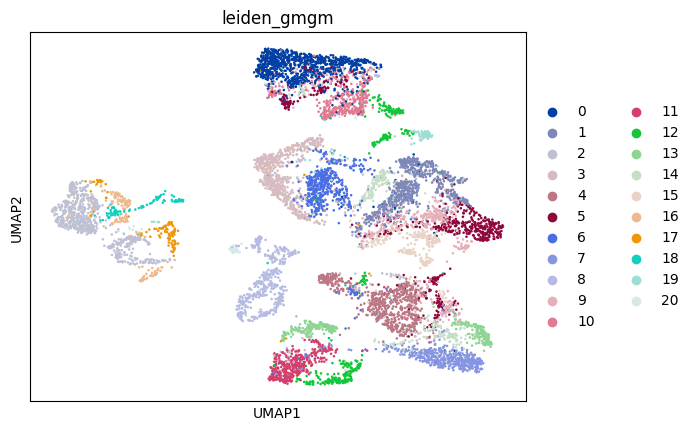

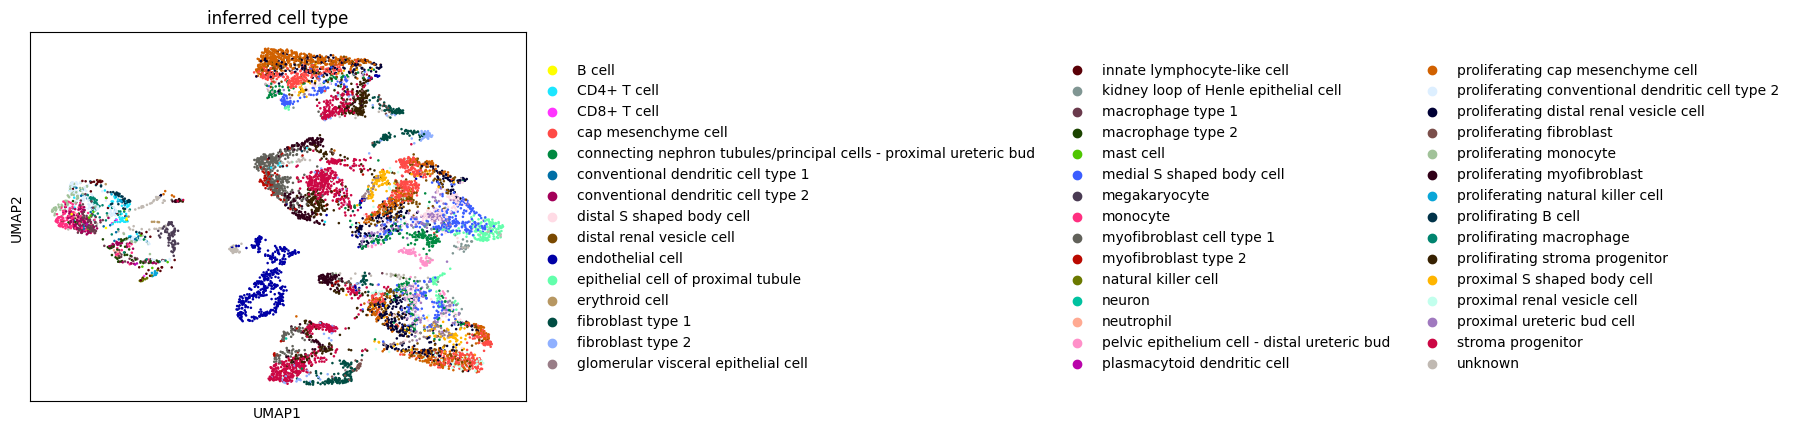

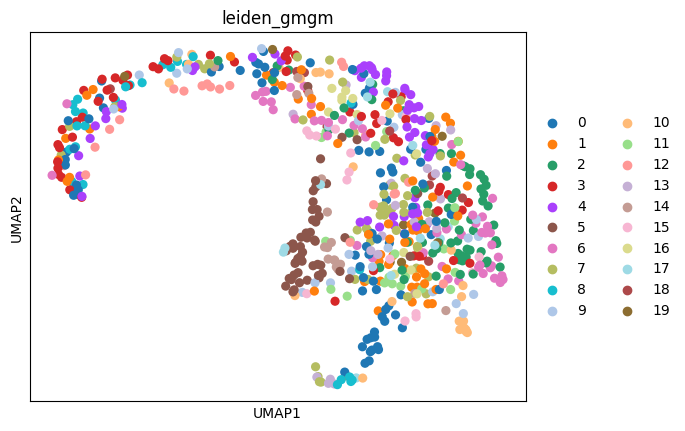

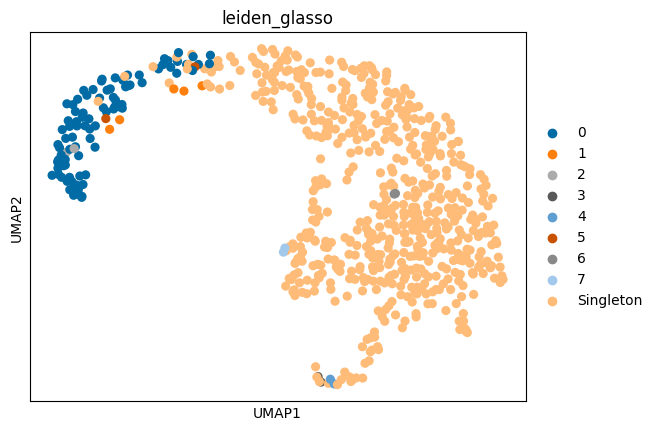

In [26]:
sc.pl.umap(gadata, color=['leiden_gmgm'])
sc.pl.umap(gadata, color=['inferred cell type'])
sc.pl.umap(fbdata, color=['leiden_gmgm'])
sc.pl.umap(fbdata, color=['leiden_glasso'])

# Gene analysis

In this section, we are interested in the structure of our gene graph.  First, we will take a look at subsets of the graph that we expect to be highly connected.  For example, ribosomal genes, mitochondrial genes, and heat shock genes.

This is somewhat limited by our filtering of genes.  Try re-running the algorithm with less genes filtered if you wish to investigate other gene groups!

In [27]:
# This cell contains the code that will plot our gene subsets

shape_palette = 100*[
   "circle",
   "rect",
   "diamond",
   "triangle",
   "rect",
   "circle",
   "triangle"
]
color_palette = 100*[
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96",
   "#264589",
   "#FF9A96"
]


def plot_info(
   name: str,
   adata: ad.AnnData,
   no_edge_weights: bool = True,
   layout: Optional[str] = None,
   graph_type: Literal['gmgm', 'glasso'] = 'gmgm'
) -> tuple[plt.Figure, plt.Axes]:
   graph = adata.obsp[f'gene_{graph_type}']
   how_many = graph.shape[0]

   try:
       # If the graph is empty, this throws an error!
       graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
   except:
       graph = ig.Graph.Weighted_Adjacency(graph)
   graph.vs["label"] = (
       adata.obs["external_gene_name"].astype(str)
       + "\n("
       + adata.obs_names.str.split('ENSG00000').str[-1]
       + ")"
   )
   graph.vs["label_size"] = 5

   # Get connected components of the graph
   components = graph.components()

   # Color vertex by component
   graph.vs["color"] = [color_palette[i] for i in components.membership]

   # Change  vertex shape by component as well
   graph.vs["shape"] = [shape_palette[i] for i in components.membership]

   graph.es["label"] = [f"{w:.2E}" for w in graph.es["weight"]]
   graph.es["label_size"] = 5

   if layout is None:
       layout = 'circle' if how_many > 15 else 'kk'


   fig, ax = plt.subplots(figsize=(7, 7))
   ig.plot(
       graph,
       vertex_size=40,
       target=ax,
       edge_color="black",
       layout=layout,
       **({} if no_edge_weights else {'edge_label': graph.es["label"]}),
   )
   ax.set_facecolor("white")
   ax.set_title(name)
   ax.set_xlabel("Colored/shaped by connected components")


   fig.suptitle(f"Connections of {name}")
   return fig, ax

#fbdata.obsp["gene_gmgm"] = sparse.csr_matrix(fbdata.obsp["gene_gmgm"])

Here, we see that GmGM is successfully able to identify that the heat shock protein genes should be highly connected.  GLasso is, unfortunately, not able to notice this - the gene group is fully disconnected.

/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


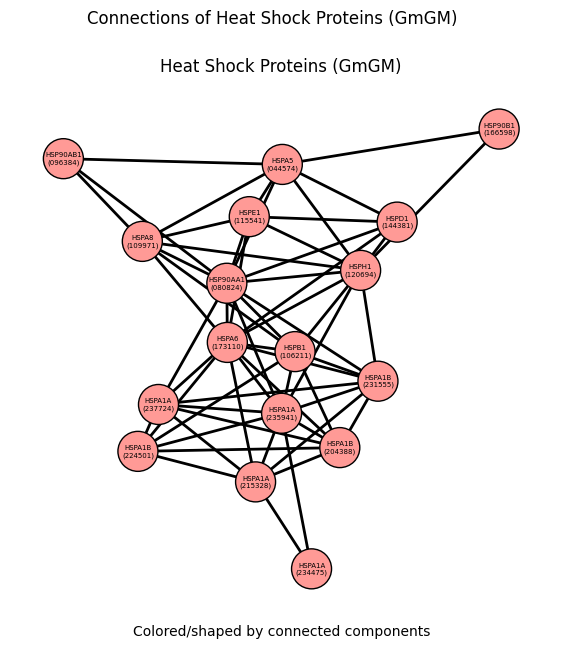

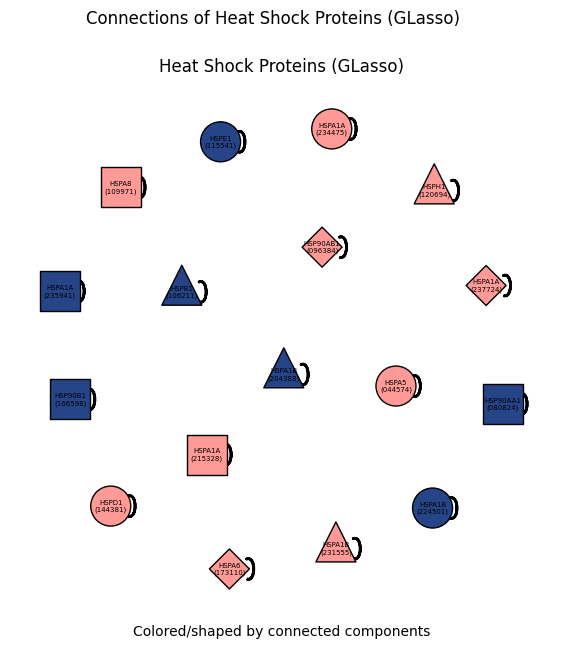

In [28]:
hsp = fbdata[fbdata.obs["external_gene_name"].str.startswith("HSP")]

plot_info(
   "Heat Shock Proteins (GmGM)",
   hsp,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Heat Shock Proteins (GLasso)",
   hsp,
   layout='fr',
   graph_type='glasso'
)
pass

We can also check if mitochondrial genes tend to be highly connected.  Some mitochondrial genes are building blocks of the same end product (such as NADH Dehydrogenase and Cytochrome C Oxidase), so we could reasonably expect at least that these subsets be connected.

Both algorithms find mitochondrial genes to be highly connected, although GLasso is missing the connections for several NADH-dehydrogenase-related genes.

/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


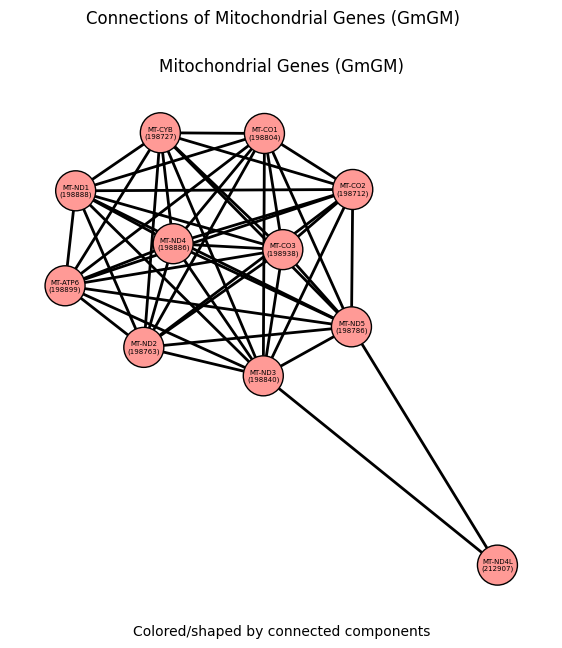

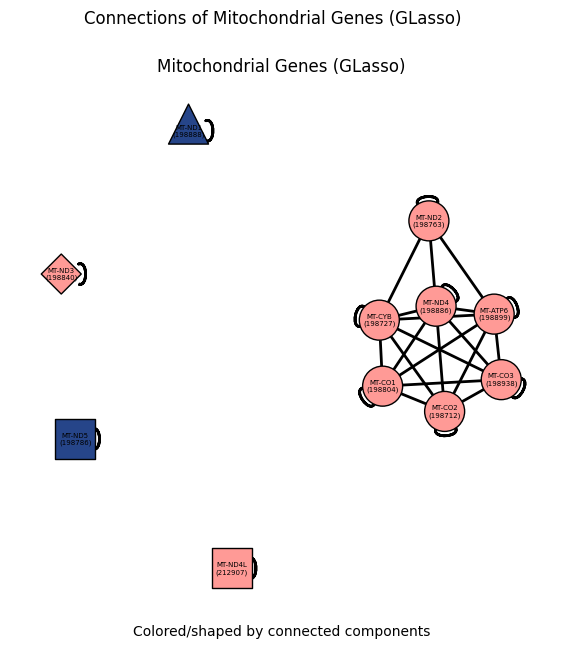

In [29]:
mitochondrial = fbdata[fbdata.obs["external_gene_name"].str.startswith("MT-")]

plot_info(
   "Mitochondrial Genes (GmGM)",
   mitochondrial,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Mitochondrial Genes (GLasso)",
   mitochondrial,
   layout='fr',
   graph_type='glasso'
)
pass

Now, let's look at small ribosomal proteins, which we expect should be highly connected.  This is absolutely true for GLasso, but less true for GmGM where the graph has several disconnected components.  Some of these, such as RPS9 and RPS18, correspond to components connecting variant alleles of the same gene.

/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


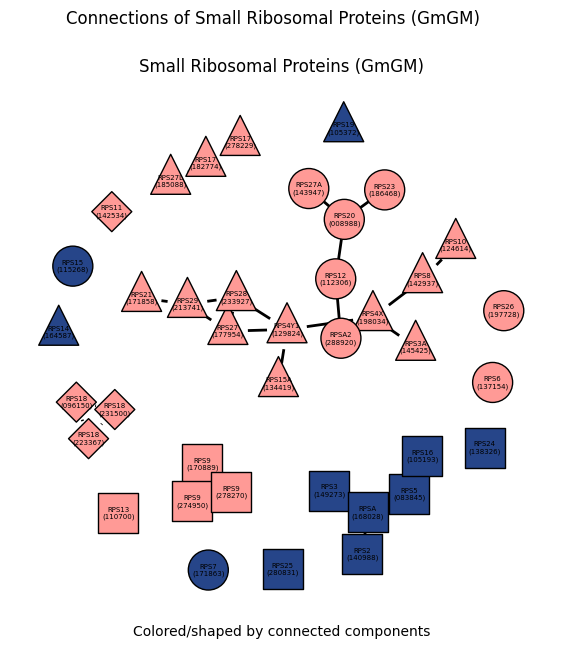

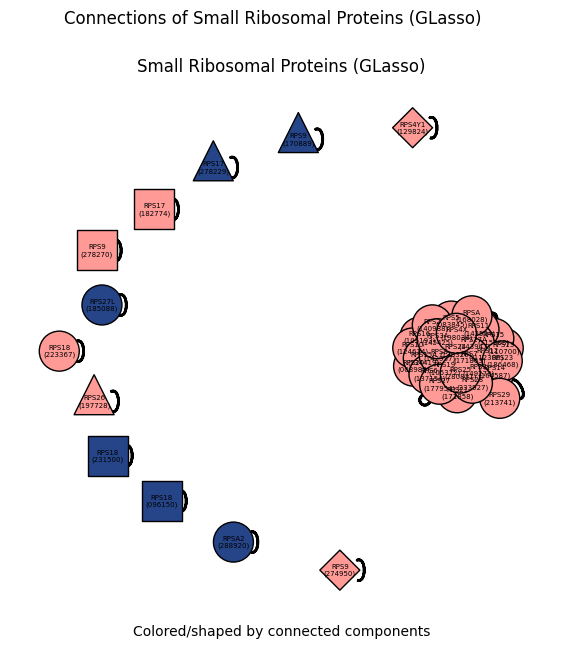

In [30]:
rps = fbdata[fbdata.obs["external_gene_name"].str.startswith("RPS")]

plot_info(
   "Small Ribosomal Proteins (GmGM)",
   rps,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Small Ribosomal Proteins (GLasso)",
   rps,
   layout='fr',
   graph_type='glasso'
)
pass

Finally, we can do the same test on large ribosomal genes.  In this case, both algorithms do well; not every gene is connected, but the grand majority are.  They also seem to mostly agree on which genes are not connected.

Interestingly, GLasso gives a much denser graph than GmGM.  Combined with GLasso's poor performance on heat shock proteins, this would indicate that GLasso is mostly focusing on connections between the most active genes (such as ribosomal genes), whereas GmGM has a more spead out set of connections.

/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (
/tmp/ipykernel_51688/3500977130.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph.vs["label"] = (


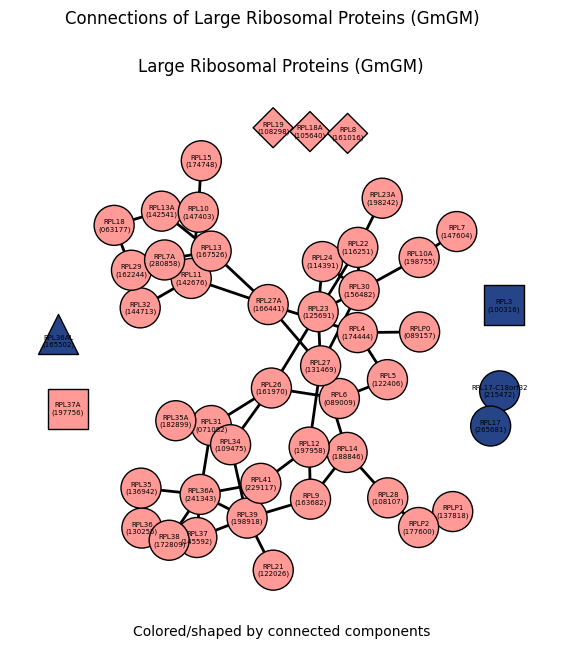

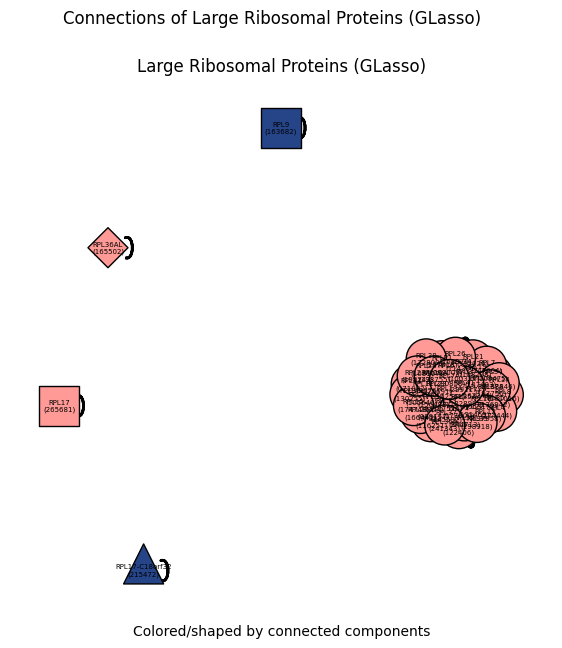

In [31]:
rpl = fbdata[fbdata.obs["external_gene_name"].str.startswith("RPL")]

plot_info(
   "Large Ribosomal Proteins (GmGM)",
   rpl,
   layout='fr',
   graph_type='gmgm'
)
plot_info(
   "Large Ribosomal Proteins (GLasso)",
   rpl,
   layout='fr',
   graph_type='glasso'
)
pass

Can you think of any other groups of genes?  If so, feel free to run your own analysis in the cell below.  Remember that most genes have been filtered out, so you will either want to pick a gene group that is common, or re-run the analysis with a larger set of genes.

In [32]:
# Put your own gene groups here

## Gene Module Analysis

In the previous section, we looked at the connectivity between pre-defined groups of cells.  In this section, we will look at the clusterings we produced earlier and if they correspond to known groups of genes.

In [33]:
# This cell will download a list of GO terms associated with each cluster.
def create_pathway_df(
    adata: ad.AnnData,
    graph_type: str,
) -> pd.DataFrame:

    leiden_string = f"leiden_{graph_type}"

    gp = GProfiler(return_dataframe=True)
    pathway_df = gp.profile(
        organism="hsapiens",
        query={
            f"Module {module}": adata[adata.obs[leiden_string] == module].obs_names.values.tolist()
            for module in adata.obs[leiden_string].unique()
        }
    )

    pathway_df.to_csv(f"../results/pathways_{graph_type}.csv")

    return pathway_df

pathway_df_gmgm = create_pathway_df(fbdata, "gmgm")
pathway_df_glasso = create_pathway_df(fbdata, "glasso")

In [34]:
# This is a helper function to generate our results for each cluster; run it, but don't worry too much about understanding the internals
# if you feel you are strapped for time.
def plot_graph(
    adata: ad.AnnData,
    module: str,
    key: str,
    pathway_df: pd.DataFrame,
    graph_type: Literal["glasso", "gmgm"],
    obsp_or_varp: Literal["obsp", "varp"] = "obsp",
    vertex_names: Optional[str] = None,
    top_genes: int = 25,
    top_pathways: int = 10,
    display_centrality: Literal["degree", "harmonic", "eigenvector_centrality", "betweenness"] = "degree",
    save: bool = True,
) -> tuple[tuple[plt.Figure, plt.Axes], ig.Graph]:
    leiden_string = f"leiden_{graph_type}"
    key = f"{key}_{graph_type}"
    # Create the graph for the specific module
    if obsp_or_varp == "obsp":
        module_idx = adata.obs[leiden_string] == module
        name_source = adata[module_idx].obs_names
        id = adata[module_idx].obs_names
        if vertex_names is not None:
            name_source = adata[module_idx].obs[vertex_names]
        full_graph = adata[module_idx].obsp[key]
    elif obsp_or_varp == "varp":
        module_idx = adata.var[leiden_string] == module
        name_source = adata[module_idx].var_names
        id = adata[module_idx].var_names
        if vertex_names is not None:
            name_source = adata[module_idx].var[vertex_names]
        full_graph = adata[module_idx].varp[key]
    else:
        raise ValueError("obsp_or_varp must be either 'obsp' or 'varp'")
    
    full_graph = ig.Graph.Weighted_Adjacency(full_graph, mode="undirected")
    full_graph.vs["label"] = name_source
    full_graph.vs["label_size"] = 10

    # Measure how central each gene is
    centrality_measures = pd.DataFrame(
            index=id,
            data={
                "names": full_graph.vs["label"],
                "degree": full_graph.degree(),
                "harmonic": full_graph.harmonic_centrality(),
                "eigenvector_centrality": full_graph.eigenvector_centrality(),
                "betweenness": full_graph.betweenness(),
            }
    )

    full_graph.vs["degree"] = centrality_measures["degree"]
    full_graph.vs["harmonic"] = centrality_measures["harmonic"]
    full_graph.vs["eigenvector_centrality"] = centrality_measures["eigenvector_centrality"]
    full_graph.vs["betweenness"] = centrality_measures["betweenness"]

    centrality_measures = centrality_measures.sort_values(display_centrality, ascending=False)
    ranked = centrality_measures[display_centrality]

    # Subset the graph to just the most central genes
    name_source = centrality_measures.head(top_genes)["names"]
    idxs = centrality_measures.head(top_genes).index
    if obsp_or_varp == "obsp":
        graph = adata[idxs].obsp[key]
    elif obsp_or_varp == "varp":
        graph = adata[idxs].varp[key]
    else:
        raise ValueError("obsp_or_varp must be either 'obsp' or 'varp'")
    

    # Plot and save the graph
    graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected")
    graph.vs["label"] = name_source
    graph.vs["label_size"] = 7
    fig, ax = plt.subplots(figsize=(7, 7))
    ig.plot(
        graph,
        vertex_size=50,
        target=ax,
        edge_color="black",
    )
    ax.set_facecolor("grey")
    ax.set_title(f"Module {module}; top {top_genes} genes by {display_centrality}")
    if save:
        # Check if m{module} exists; if not, create it
        if not os.path.exists(f"../results/{graph_type}/m{module}"):
            os.makedirs(f"../results/{graph_type}/m{module}")
        else:
            # If it already exists, remove the old contents
            shutil.rmtree(f"../results/{graph_type}/m{module}")
            os.makedirs(f"../results/{graph_type}/m{module}")
       
        plt.savefig(f"../results/{graph_type}/m{module}/graph.png")

        # Save the centrality measures
        centrality_measures.to_csv(f"../results/{graph_type}/m{module}/centrality_measures.csv")

        # Save the list of top N genes
        centrality_measures["names"].head(top_genes).to_csv(
            f"../results/{graph_type}/m{module}/top_genes.csv",
            index=False,
            header=False,
            sep=",",
        )

        # Select the top 10 pathways for relevant sources
        module_df = pathway_df[pathway_df["query"] == f"Module {module}"]
        res = pd.concat([
            module_df[module_df["source"] == "GO:BP"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:CC"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:MF"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "KEGG"].head(top_pathways)[["source", "native", "name", "p_value"]],
        ])
        res.to_csv(f"../results/{graph_type}/m{module}/top_pathways.csv", index=False)

    return (fig, ax), graph

Now we will look at the gene modules.  Drawing all of them into the notebook would bog down the notebook's memory and speed, so instead we will be saving the results to the folder `results/gmgm` and `results/glasso` - take a look in your file browser on the left hand side after running the next cell!

The only results for GLasso are that the first module relates to ribosomal genes and second to mitochondrial genes - all other clusters are too small to be significant.

GmGM, on the other hand, has many relevant clusters. You can look at the `top_pathways` file to see the top significant GO terms associated with each cluser, and `graph.png` to see a graph of the top 25 "most central" genes in each cluster.

In [35]:
print("Creating results...")

# Overwrite old results, if they exist
if os.path.exists(f"../results/gmgm"):
    shutil.rmtree(f"../results/gmgm")

if os.path.exists(f"../results/glasso"):
    shutil.rmtree(f"../results/glasso")

# Generate new results
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for module in fbdata.obs["leiden_gmgm"].unique():
        if module == "Singleton":
            continue

        (fig, _), _ = plot_graph(
            fbdata,
            module,
            key="gene",
            pathway_df=pathway_df_gmgm,
            graph_type="gmgm",
            save=True,
            vertex_names="external_gene_name",
            top_genes=25,
            top_pathways=10,
            display_centrality="degree",
        )

        # Close figures to prevent notebook slowing down.
        plt.close(fig)

    for module in fbdata.obs["leiden_glasso"].unique():
        if module == "Singleton":
            continue

        (fig, _), _ = plot_graph(
            fbdata,
            module,
            key="gene",
            pathway_df=pathway_df_glasso,
            graph_type="glasso",
            save=True,
            vertex_names="external_gene_name",
            top_genes=25,
            top_pathways=10,
            display_centrality="degree",
        )



        # Close figures to prevent notebook slowing down.
        plt.close(fig)

print("Done!")


Creating results...
Done!


# Cell Analysis

In this section, we will look at how good our cell graphs are.  We could not get GLasso to run in reasonable time for the cell graphs, and hence here we only look at GmGM's results.

We will analyze the results by comparing our clusters to known properties of the cells.  The creators of the dataset assigned each cell a cell type, as well as kept track of some other information (if you print adata and look at the "obs" field, you will see a list of all known cell properties); here, we will just look at cell type, and leave it to the reader to augment the analysis with the investigation of other properties.

In [36]:
# These functions will be useful for our analysis
def jaccard(x: set, y: set) -> float:
    return len(x & y) / len(x | y)

def dice(x: set, y: set) -> float:
    return 2 * len(x & y) / (len(x) + len(y))

def overlap(x: set, y: set) -> float:
    return len(x & y) / min(len(x), len(y))

def get_overlap(x: set, y: set, OVERLAP_METHOD: str) -> float:
    if OVERLAP_METHOD == "overlap":
        return overlap(x, y)
    elif OVERLAP_METHOD == "dice":
        return dice(x, y)
    elif OVERLAP_METHOD == "jaccard":
        return jaccard(x, y)
    else:
        raise ValueError(f"Unknown method {OVERLAP_METHOD}")    

Let's look at how well our clusters agree with the labeled cell type.

Here, we will use the "overlap" metric - if one of our clusters entirely contains all cells of a given type (or vice versa), it will have a score of 1.  If they are completely disjoint, the score will be zero.  We would hope to see many "1"s in our matrix of overlaps.

If a cluster contains all of many cell types, it will contain many "1"s; we would then hope that a finer-grained clustering would allow distinguishing those cell types.

This dataset is difficult in the sense that the cell typing is quite fine-grained.

In [37]:
# This cell should take 10-20 seconds to run
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata.obs['leiden_gmgm'].nunique(),
    gadata.obs['inferred cell type'].nunique()
))

for my_cluster in gadata.obs['leiden_gmgm'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata.obs['inferred cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata[gadata.obs["leiden_gmgm"] == my_cluster].obs_names),
            set(gadata[gadata.obs['inferred cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

# The results of this cell are plotted in the next

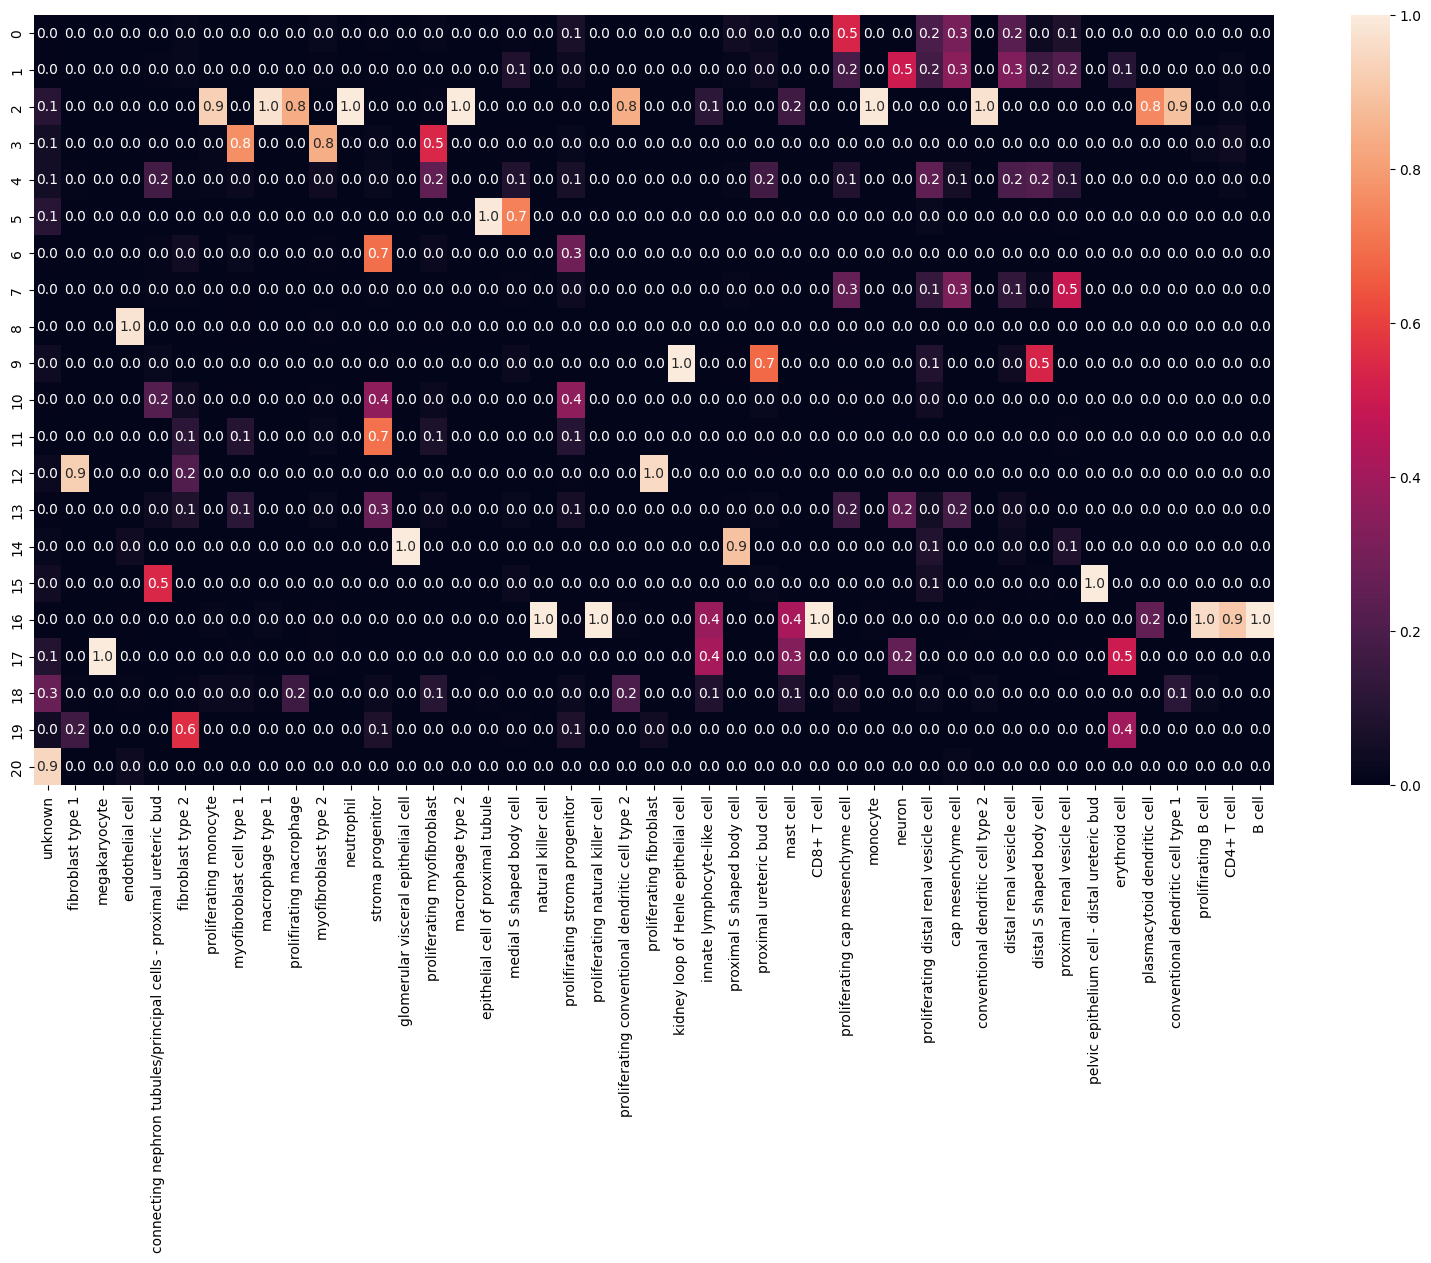

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata.obs['inferred cell type'].unique()
ys = np.arange(gadata.obs['leiden_gmgm'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

So we do often see lots of strong overlap within clusters. Some clusters seem too coarsly grained - for example, cluster 2 covers monocytes, macrophages, dendritic cells, and neutrophils.  Later, we will focus in on this cluster and see if further division can separate these cell types.

First, let's combine similar cell types (such as grouping all macrophages together), and see how that affects the results.

In [39]:
gadata.obs["coarse cell type"] = gadata.obs["inferred cell type"].astype(str)
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("macrophage"), "coarse cell type"] = "macrophage"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("fibroblast"), "coarse cell type"] = "fibroblast"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("monocyte"), "coarse cell type"] = "monocyte"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("conventional dendritic"), "coarse cell type"] = "conventional dendritic"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("T cell"), "coarse cell type"] = "T cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("natural killer cell"), "coarse cell type"] = "natural killer cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("body cell"), "coarse cell type"] = "body cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("epithelial cell"), "coarse cell type"] = "epithelial cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("mesenchyme cell"), "coarse cell type"] = "mesenchyme cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("vesicle cell"), "coarse cell type"] = "vesicle cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("B cell"), "coarse cell type"] = "B cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("bud"), "coarse cell type"] = "bud cell"
gadata.obs.loc[gadata.obs["coarse cell type"].str.contains("stroma progenitor"), "coarse cell type"] = "stroma progenitor"
gadata.obs["coarse cell type"].unique()

array(['unknown', 'fibroblast', 'megakaryocyte', 'endothelial cell',
       'bud cell', 'monocyte', 'macrophage', 'neutrophil',
       'stroma progenitor', 'epithelial cell', 'body cell',
       'natural killer cell', 'conventional dendritic',
       'innate lymphocyte-like cell', 'mast cell', 'T cell',
       'mesenchyme cell', 'neuron', 'vesicle cell', 'erythroid cell',
       'plasmacytoid dendritic cell', 'B cell'], dtype=object)

In [40]:
# This cell should take a few seconds to run
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata.obs['leiden_gmgm'].nunique(),
    gadata.obs['coarse cell type'].nunique()
))

for my_cluster in gadata.obs['leiden_gmgm'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata.obs['coarse cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata[gadata.obs["leiden_gmgm"] == my_cluster].obs_names),
            set(gadata[gadata.obs['coarse cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

# The results of this cell are plotted in the next

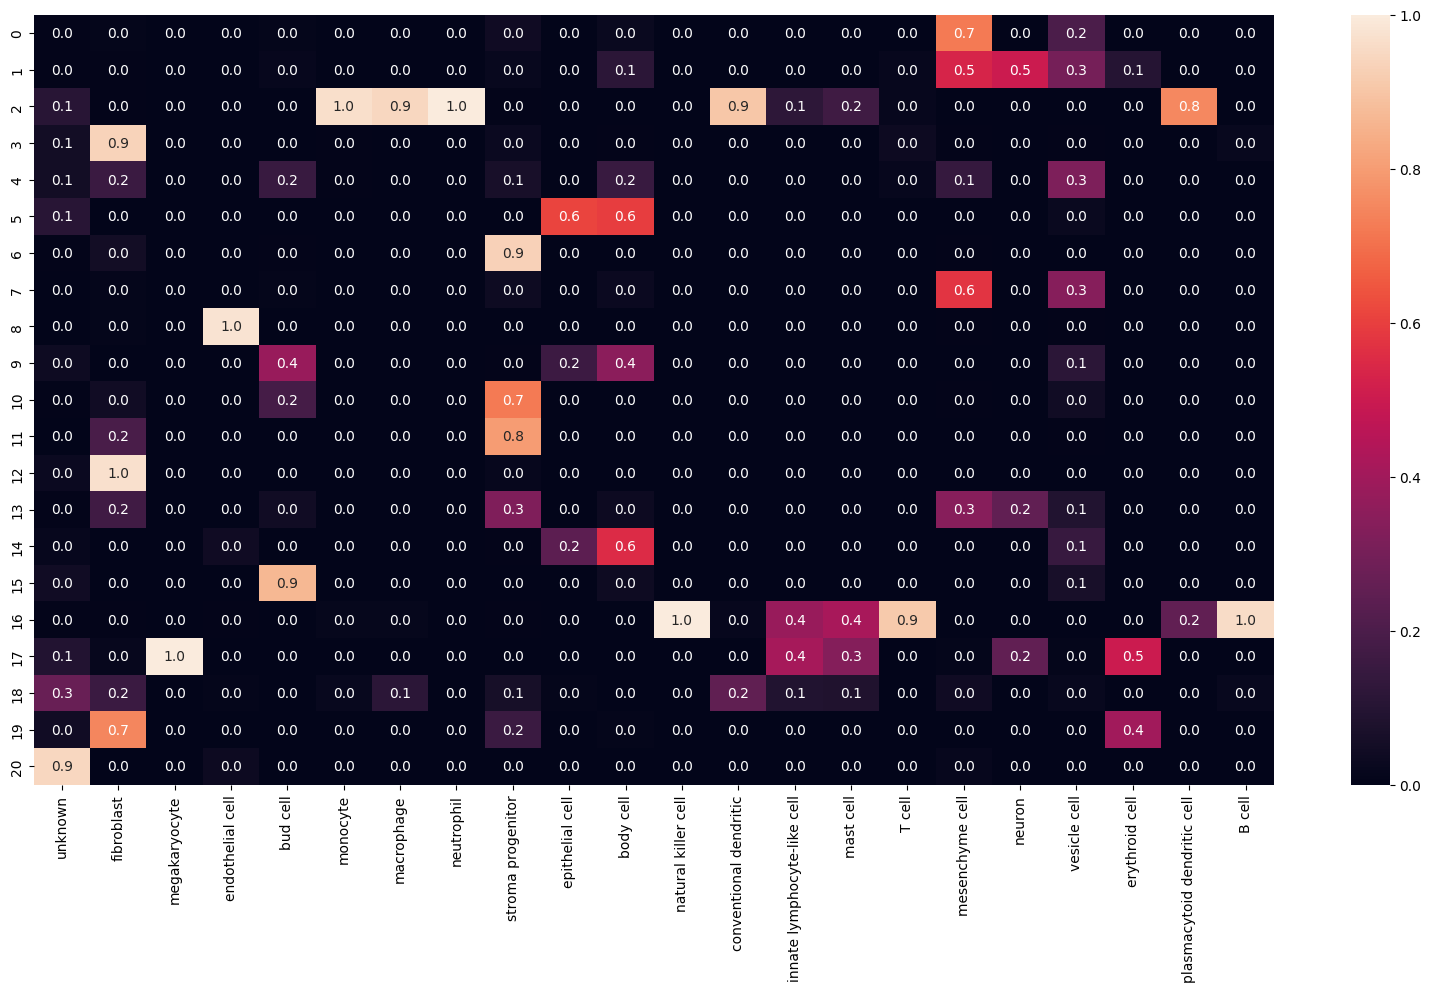

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata.obs['coarse cell type'].unique()
ys = np.arange(gadata.obs['leiden_gmgm'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

This allows us to assign each cluster a grouping of cells:

0) **Mesenchyme cells**
1) Mesenchyme, neuron, and vesicle cells
2) Monocyte, macrophage, neutrophil, and (conventional/plasmacytoid) dendritic cells
3) **Fibroblasts**
4) No strong relation, vesicles to an extent
5) Epithelial and body cells
6) **Stroma progenitors**
7) Mesenchyme and vesicle cells
8) **Endothelial cells**
9) Bud and body cells
10) **Stroma progenitor**
11) **Stroma progenitor**
12) **Fibroblast**
13) No strong overlap, weakly spread out over a few
14) **Body cells**
15) **Bud cells**
16) Natural killer cells, lymphocyte-like cells, mast cells, T cells, and B cells
17) Megakaryocyte, lymphocyte-like cells, mast cells, erythoid cells
18) No strong relations
19) Fibroblast and erythoid cells
20) **Unclassified cells**

Several of these could be broken up into smaller groups.  As promised, let's look deeper into cluster 2 to see if we can distinguish its constituent cell types.

In [42]:
# AnnData and scanpy are a work-in-progress; at the time of writing this tutorial,
# they do not have great support for the new "array api" of sparse matrices,
# rather still relying on the (long-since-deprecated) "matrix api".
# If we don't cast this to the matrix API, it will cause an error message later.
# This is a technical nuisance that will hopefully be fixed by AnnData fairly soon.
#gadata.obsp["cell_gmgm"] = sparse.csr_matrix(gadata.obsp["cell_gmgm"])


gadata_2 = gadata[gadata.obs["leiden_gmgm"] == "2"]
gadata_2

View of AnnData object with n_obs × n_vars = 705 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[in

In [43]:
sc.tl.leiden(
    gadata_2,
    key_added="leiden_gmgm_2",
    obsp='cell_gmgm'
)
gadata_2

/home/codespace/.python/current/lib/python3.10/site-packages/scanpy/tools/_leiden.py:199: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


AnnData object with n_obs × n_vars = 705 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual

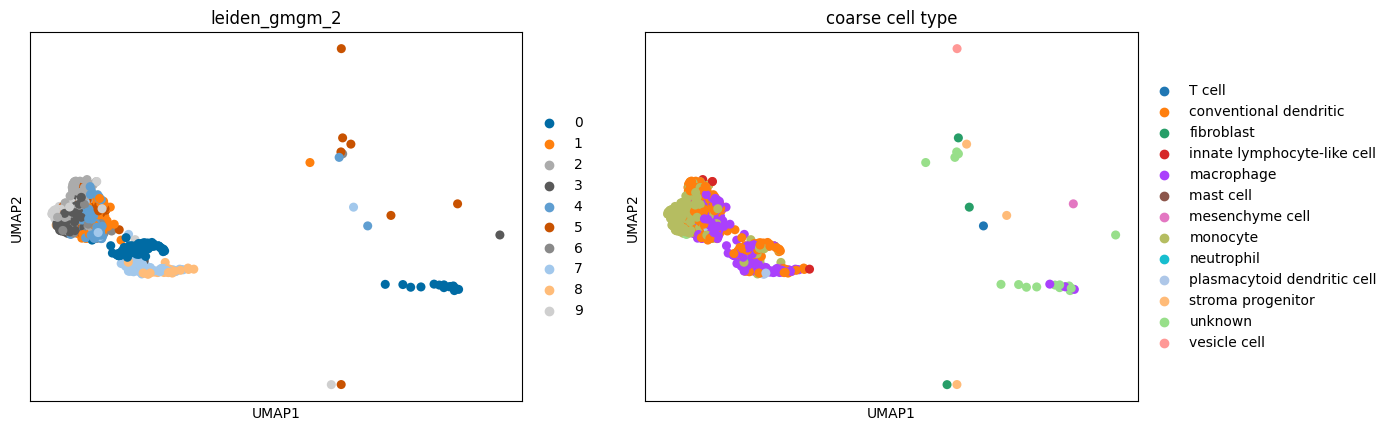

In [44]:
sc.pl.umap(gadata_2, color=['leiden_gmgm_2', 'coarse cell type'])

In [45]:
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata_2.obs['leiden_gmgm_2'].nunique(),
    gadata_2.obs['coarse cell type'].nunique()
))

for my_cluster in gadata_2.obs['leiden_gmgm_2'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata_2.obs['coarse cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata_2[gadata_2.obs["leiden_gmgm_2"] == my_cluster].obs_names),
            set(gadata_2[gadata_2.obs['coarse cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

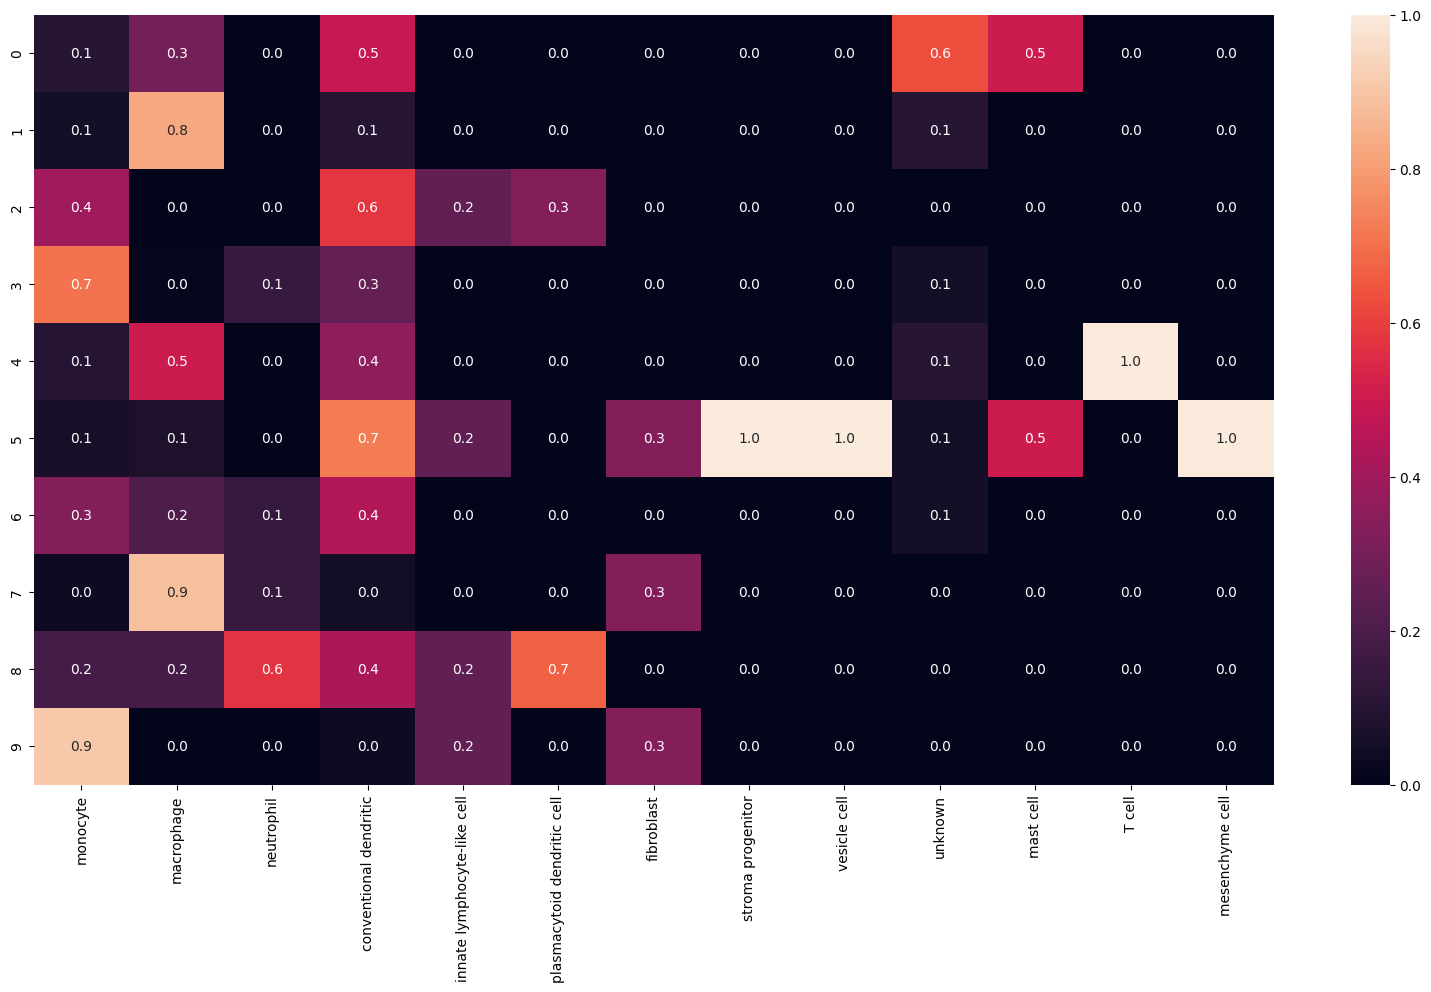

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['coarse cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Now that we've zoomed in, it's a bit messier - so let's look at the four cell types we mentioned above and see if they are separated.

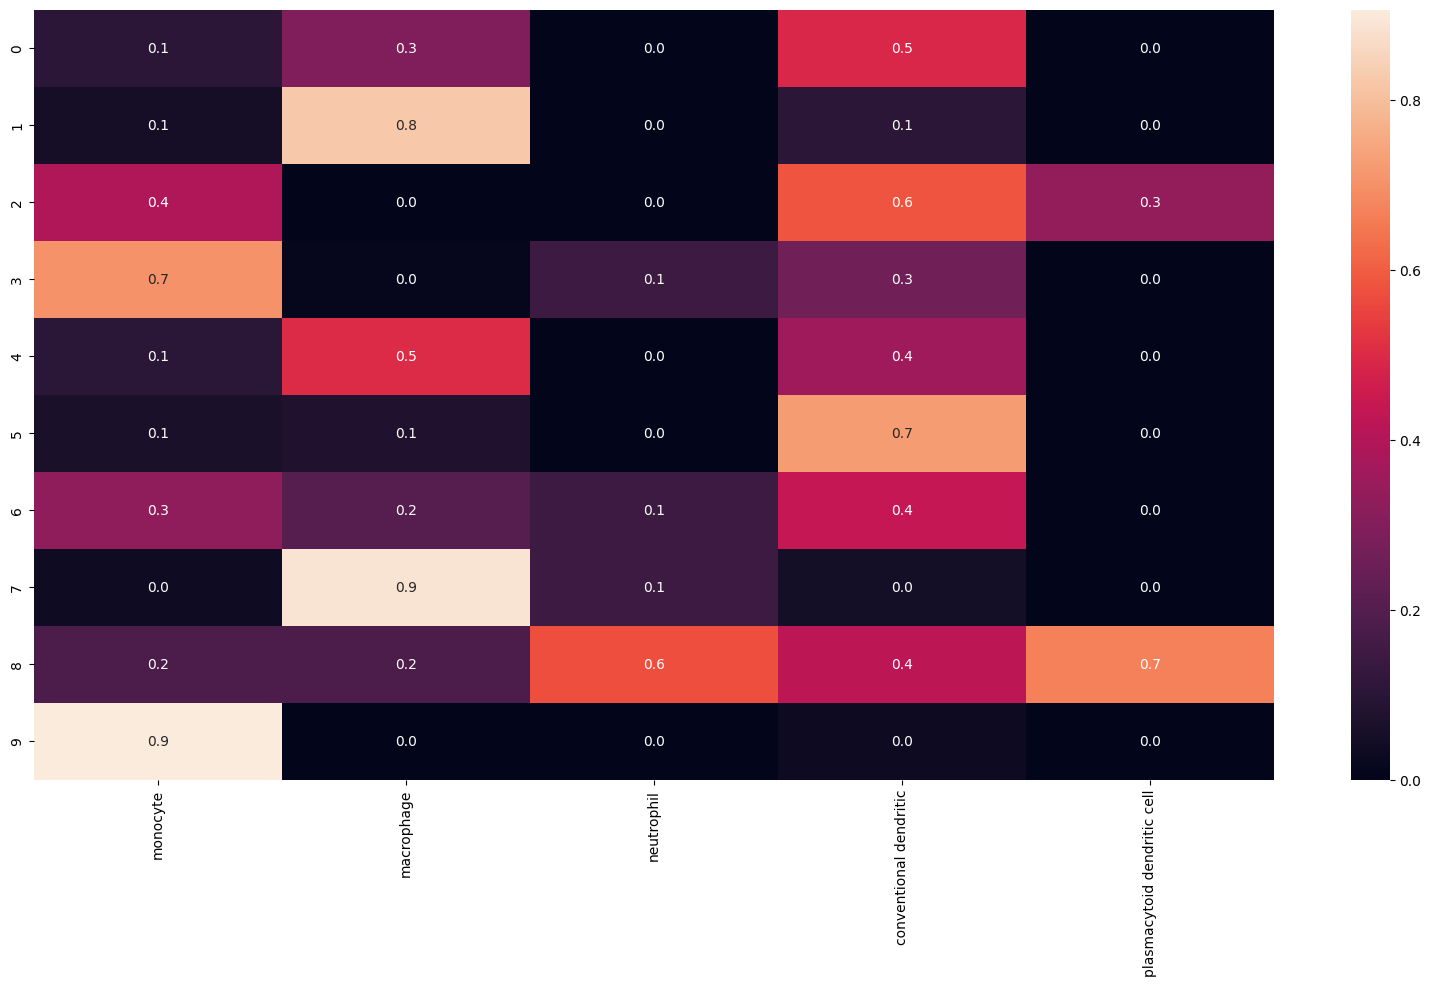

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['coarse cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
idxs = ['macrophage' in x or 'monocyte' in x or 'neutrophil' in x or 'dendritic' in x for x in xs]
sns.heatmap(confusion[:, idxs], annot=True, xticklabels=xs[idxs], yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

Final results:

0) **Dendritic**

1) **Macrophage**

2) Monocyte, Dendritic

3) **Monocyte**

4) Macrophage, Dendritic (+ t cells)

5) **Dendritic** (+ proliferating and progenitor cells)

6) **Dendritic**

7) **Macrophage**

8) Neutrophil, Dendritic, Plasmacytoid Dendritic

9) **Monocyte**

The cells in parentheses are 'contaminants'; they are present in very low quantities in this cluster, which can be seen by looking with Jaccard similarity (below).

Overlap similarity, what we were using before, is maximized when one class is contained in the other - so if there is only 1 T cell, then it will have a high overlap with whatever cluster it happens to be assigned with.

This is useful in trying to find out which clusters contain which cell types, but is susceptible to this small-class problem.  Jaccard, on the other hand, is maximized when the classes are equal - not just contained in one another.

In [48]:
OVERLAP_METHOD = "jaccard"

# Create confusion matrix
confusion = np.zeros((
    gadata_2.obs['leiden_gmgm_2'].nunique(),
    gadata_2.obs['coarse cell type'].nunique()
))

for my_cluster in gadata_2.obs['leiden_gmgm_2'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata_2.obs['coarse cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata_2[gadata_2.obs["leiden_gmgm_2"] == my_cluster].obs_names),
            set(gadata_2[gadata_2.obs['coarse cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

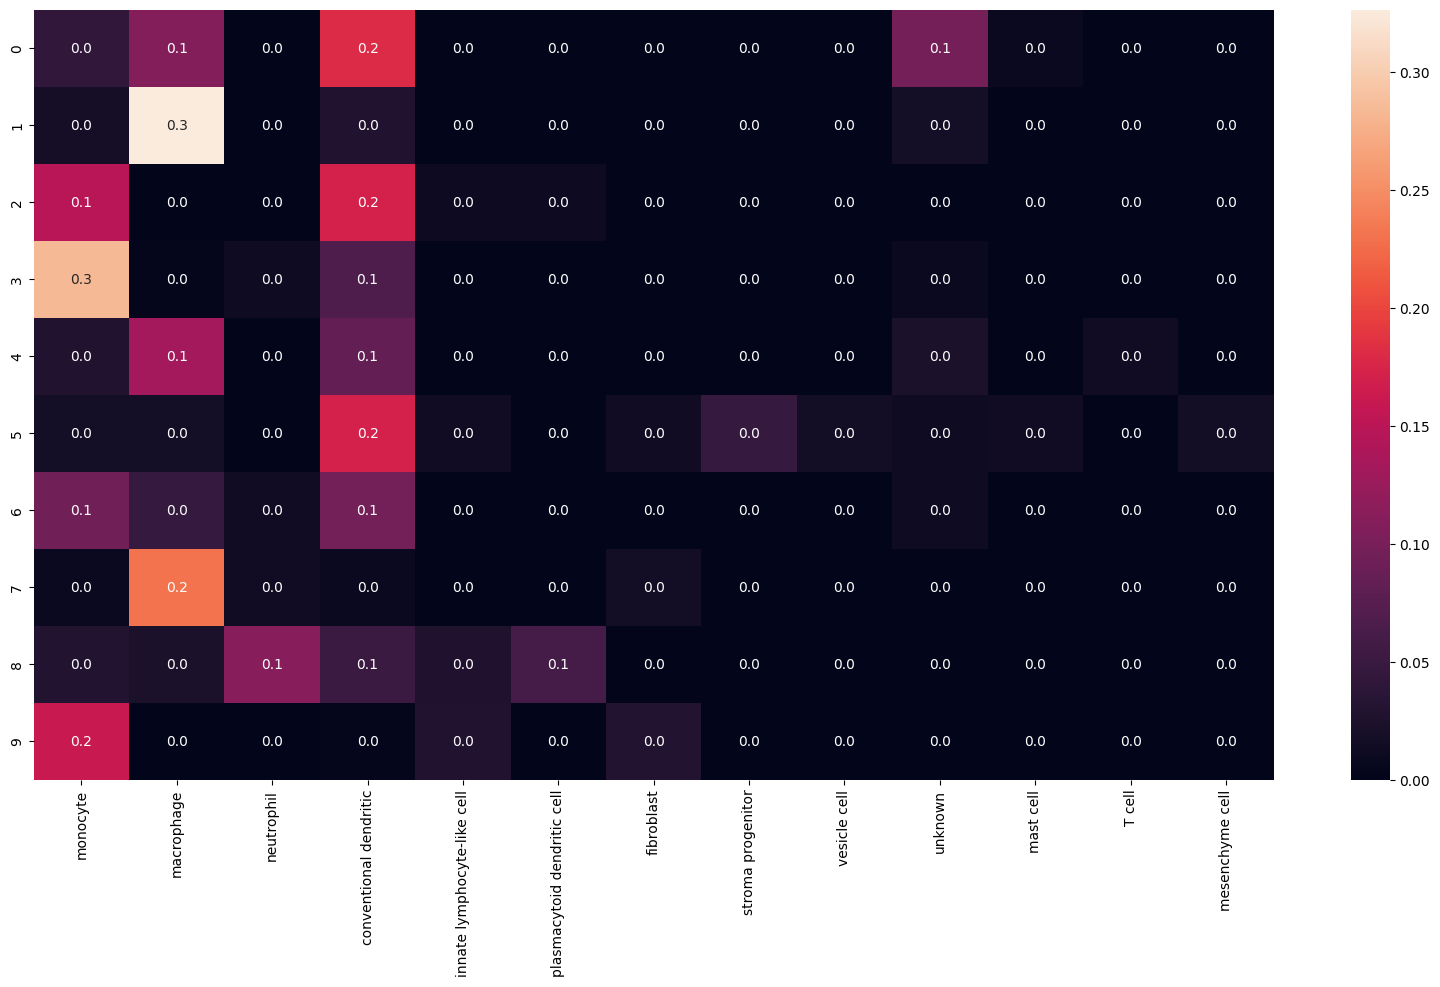

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata_2.obs['coarse cell type'].unique()
ys = np.arange(gadata_2.obs['leiden_gmgm_2'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass

# Conclusion

That's the end of this tutorial!  Feel free to keep investigating this dataset; we've given a few tips as to what you may want to investigate, but here's a recap:

1) Try changing the cutoff values in preprocessing
2) Try normalizing the cells to have their counts sum to one
3) Investigate different parameter values of GLasso and GmGM
4) Look at other gene groups and how well they connect
5) Look at other 'big tent' cell clusters and see if a finer clustering can distinguish them
6) Look at different information about the cells, rather than cell type, and how well it overlaps with our clustering